In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [4]:
from models.base_model import BaseModel

# from agents.REINFORCE_discrete import ActorCriticDiscrete
from agents.REINFORCE import REINFORCEDiscrete
from agents.advantage_estimator import state_value_estimator, gae_estimator

from trainer import build_trainer

from utils.callback import tqdm_callback

In [12]:
actor_lr = 1e-4
critic_lr = 1e-3

discount = 0.99

num_envs = 8

iters = 12000

max_episode_steps = 500

env_name = "CartPole-v1"

In [6]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).n

In [13]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(42)
    
    dummy = jnp.ones([1, obs_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(), nn.Dense(features = action_size)])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseModel(), nn.Dense(features = 1)])
    critic_params = critic_model.init(critic_init_key, dummy)['params']
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = REINFORCEDiscrete(gae_estimator(discount, 0.95))
    
    all_rewards = jnp.zeros((iters, 1))
    
    fori_body = build_trainer(agent, env, env_params, num_envs, obs_size, max_episode_steps, tqdm_callback(iters))
    
    carry = (actor, critic, all_rewards, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

100%|██████████| 12000/12000 [06:59<00:00, 30.67it/s, Reward=500.0]    

In [17]:
# actor_params
carry[0].params

{'layers_0': {'layers': {'layers_0': {'bias': Array([ 0.12005404, -0.02085264,  0.0015206 ,  0.12134529,  0.15906228,
           -0.09147969,  0.18503466, -0.01692677,  0.13740031,  0.05479249,
            0.0197404 ,  0.19555588,  0.14949313, -0.04126368, -0.10267539,
            0.13871792,  0.09652971,  0.12747839,  0.02352169,  0.15408915,
           -0.05051946,  0.09652061,  0.07588419,  0.14319737, -0.02972141,
            0.11531217,  0.17513256,  0.13821767,  0.06117738,  0.05421194,
           -0.03179806,  0.04045701, -0.08173332, -0.03284141, -0.0490372 ,
            0.15248393, -0.00815676,  0.16059424,  0.10902665,  0.07425608,
            0.03710008,  0.13997804,  0.15644437, -0.0177726 ,  0.00572602,
            0.15775412,  0.1525428 ,  0.11750671,  0.19146141,  0.10866319,
           -0.0683853 ,  0.00165288,  0.13255039, -0.01910013, -0.04363126,
           -0.04509883,  0.11909343,  0.18628116,  0.12946495,  0.17765793,
            0.01066195, -0.05467633, -0.059137

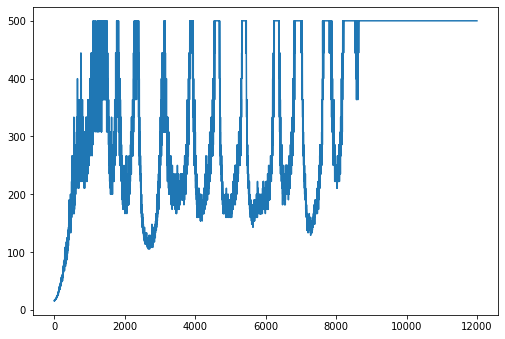

In [14]:
plt.clf()
plt.plot(carry[-2][:])
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

MovieWriter imagemagick unavailable; using Pillow instead.


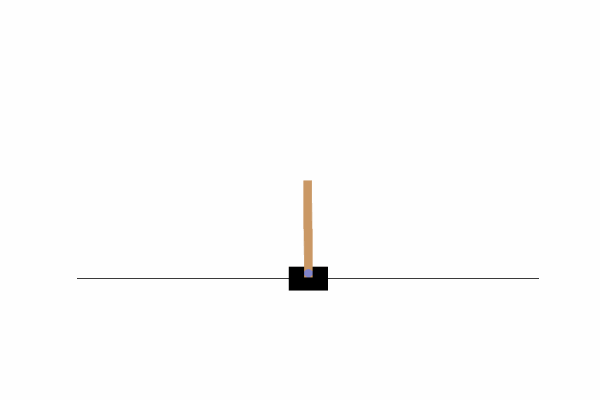

In [15]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm
import gym

actor = carry[0]

gym_env = gym.make(env_name, render_mode="rgb_array")

obs, _ = gym_env.reset()
frames = []
for t in tqdm(range(500)):
    frames.append(gym_env.render())
    action = agent.suggest_action(jnp.expand_dims(obs, 0), actor)[0]
    obs, _, done, _, _ = gym_env.step(action.item())
    if done:
        break
        
gym_env.close()

save_frames_as_gif(frames, filename = "tmp.gif")

Image(open('tmp.gif','rb').read())